# Deep Learning and Inverse Problems - Summer 2024
## Problem Set 6 -- Solution

**Issued**: Tuesday, May 28, 2024, 1:00 pm

**Due**: Tuesday, June 04, 2024, 1:00 pm

# Noise2Noise vs. Supervised Denoising

In this homework, we compare supervised image denoising (Homework 4) to self-supervised denoising with the Noise2Noise strategy discussed in the lecture. Our aim is to find out, how much more data Noise2Noise needs in order to become as good as supervised learning (in terms of PSNR). For our study, we use the same setup as in Homework 4. The code below is designed to run in Google Colab. 

In [24]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import tqdm
from matplotlib import pyplot as plt
import numpy as np
import copy
import math
use_colab = False
if use_colab:
    from google.colab import drive

from unet import Unet

plt.gray()

<Figure size 640x480 with 0 Axes>

## BSDS Dataset
Running these commands in the terminal downloads the BSDS300 dataset as a `.tgz` file, unzip it and delete the `.tgz` file.

In [25]:
#!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
#!tar -xvzf BSDS300-images.tgz
#!rm BSDS300-images.tgz

In [26]:
if use_colab:
    # for this to work, you must have the directory BSDS300 in your Google drive
    drive.mount('/content/drive')
    dataset_dir = "/content/drive/MyDrive/BSDS300"
else:
    # if you have the dataset in the same directory as this notebook (locally)
    dataset_dir = "BSDS300"

train_set_dir = f"{dataset_dir}/images/train"
train_img_files = [f"{train_set_dir}/{filename}" for filename in os.listdir(train_set_dir)]

test_set_dir = f"{dataset_dir}/images/test"
test_img_files = [f"{test_set_dir}/{filename}" for filename in os.listdir(test_set_dir)]
val_img_files = test_img_files[:50]
test_img_files = test_img_files[50:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We first implement torch datasets for supervised learning and Noise2Noise. 


In [27]:
# load image from file, convert to grayscale and normalize to range [0,1]
def load_img(file):
    # open image as grayscale
    img = Image.open(file).convert("L")
    img = torch.tensor(np.array(img))
    # convert to range [0,1]
    img = img / 255.
    return img

# split an image into chunks of size chunk_size x chunks_size (no padding, no overlap)
def chunk_img(img, chunk_size):
    chunks = img.unfold(0, chunk_size, chunk_size).unfold(1, chunk_size, chunk_size).reshape(-1, chunk_size, chunk_size)
    return list(chunks)

In [28]:
class SupervisedDataset(Dataset):
    def __init__(self, img_files, noise_var, chunk_size):
        self.img_files = img_files
        self.noise_var = noise_var
        self.chunk_size = chunk_size
        self.chunks_clean, self.chunks_noisy = self.get_clean_and_noisy_chunks()

    def get_clean_and_noisy_chunks(self):
        # load clean images
        imgs_clean = [load_img(file) for file in self.img_files]
        # split into chunks
        chunks_clean = sum([chunk_img(img, chunk_size=self.chunk_size) for img in imgs_clean], [])
        # add noise to chunks
        chunks_noisy = [img + math.sqrt(self.noise_var) * torch.randn_like(img) for img in chunks_clean]
        return chunks_clean, chunks_noisy

    def __len__(self):
        return len(self.chunks_clean)

    def __getitem__(self, idx):
        return self.chunks_noisy[idx], self.chunks_clean[idx]


class Noise2NoiseDataset(Dataset):
    def __init__(self, img_files, noise_var, chunk_size):
        self.img_files = img_files
        self.noise_var = noise_var
        self.chunk_size = chunk_size
        self.chunks_noisy_0, self.chunks_noisy_1 = self.get_clean_and_noisy_chunks()

    def get_clean_and_noisy_chunks(self):
        # load clean images
        imgs_clean = [load_img(file) for file in self.img_files]
        # split into chunks
        chunks_clean = sum([chunk_img(img, chunk_size=self.chunk_size) for img in imgs_clean], [])
        # add noise to chunks
        chunks_noisy_0 = [img + math.sqrt(self.noise_var) * torch.randn_like(img) for img in chunks_clean]
        chunks_noisy_1 = [img + math.sqrt(self.noise_var) * torch.randn_like(img) for img in chunks_clean]
        return chunks_noisy_0, chunks_noisy_1

    def __len__(self):
        return len(self.chunks_noisy_0)

    def __getitem__(self, idx):
        return self.chunks_noisy_0[idx], self.chunks_noisy_1[idx]

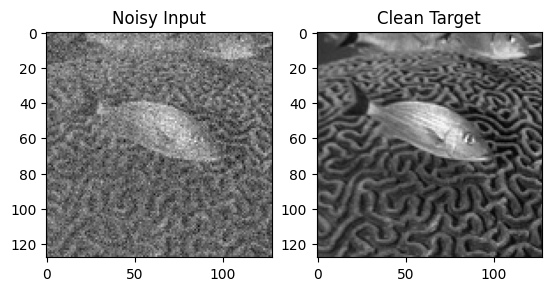

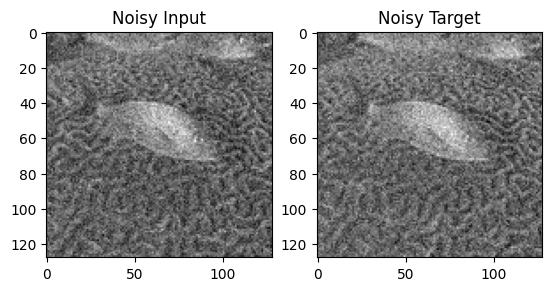

In [29]:
noise_var = 0.015  # keep this value
train_chunk_size = 128  

supervised_train_set = SupervisedDataset(img_files=train_img_files, noise_var=noise_var, chunk_size=train_chunk_size)
n2n_train_set = Noise2NoiseDataset(img_files=train_img_files, noise_var=noise_var, chunk_size=train_chunk_size)
# for validation and testing, we do not have to split the images into chunks because we do not have to compute gradients
# the images have shape (321, 481) or (481, 321) so we crop them to (321, 321) to facilitate data loading
val_set = SupervisedDataset(img_files=val_img_files, noise_var=noise_var, chunk_size=321)

fig, ax = plt.subplots(1, 2)
ax[0].set_title("Noisy Input")
ax[0].imshow(supervised_train_set[0][0])
ax[1].set_title("Clean Target")
ax[1].imshow(supervised_train_set[0][1])

fig, ax = plt.subplots(1, 2)
ax[0].set_title("Noisy Input")
ax[0].imshow(n2n_train_set[0][0])
ax[1].set_title("Noisy Target")
ax[1].imshow(n2n_train_set[0][1])

## Supervised Baseline

As a baseline, we train a U-Net for denoising in a supervised manner on a dataset of 300 chunks of size 128x128.

### Helper Functions

In [30]:
def get_psnr(gt, pred):
    pred.clamp(0, 1)
    mse = (gt-pred).pow(2).mean(dim=(-1,-2))
    return -10 * torch.log10(mse)  

def get_training_loss(imgs0, imgs1):
    return (imgs0 - imgs1).pow(2).mean(dim=(-1,-2))

def train(model, optimizer, train_loader, epochs, val_loader, check_val_every_epochs, device="cpu"):
    model.to(device)
    train_losses = {}
    val_psnrs = {}
    for e in tqdm.tqdm(range(epochs), desc="Epoch"):
        train_loss = 0.0
        for imgs_noisy, imgs_target in train_loader:
            imgs_noisy = imgs_noisy.to(device)
            imgs_target = imgs_target.to(device)
            optimizer.zero_grad()
            mean = imgs_noisy.mean(dim=(-1, -2), keepdim=True)
            std = imgs_noisy.std(dim=(-1, -2), keepdim=True)
            imgs_noisy = (imgs_noisy - mean) / std
            imgs_denoised = model(imgs_noisy.unsqueeze(1)).squeeze(1)
            imgs_denoised = imgs_denoised * std + mean
            loss = get_training_loss(imgs_target, imgs_denoised).mean()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses[e*len(train_loader.dataset)] = train_loss  # e*len(train_loader.dataset) is number of gradient updates
    
        if e % check_val_every_epochs == 0:
            with torch.no_grad():
                val_psnr = 0.0
                for imgs_noisy, imgs_clean in val_loader:
                    imgs_noisy = imgs_noisy.to(device)
                    imgs_clean = imgs_clean.to(device)
                    mean = imgs_noisy.mean(dim=(-1, -2), keepdim=True)
                    std = imgs_noisy.std(dim=(-1, -2), keepdim=True)
                    imgs_noisy = (imgs_noisy - mean) / std
                    imgs_denoised = model(imgs_noisy.unsqueeze(1)).squeeze(1)
                    imgs_denoised = imgs_denoised * std + mean
                    psnr = get_psnr(imgs_clean, imgs_denoised).mean()
                    val_psnr += psnr.item()
                val_psnr /= len(val_loader)
                val_psnrs[e*len(train_loader.dataset)] = val_psnr
    return model, train_losses, val_psnrs

In [31]:
num_pool_layers = 2
chans = 64
device = "cuda:0"  

supervised_model = Unet(
    in_chans=1,  
    out_chans=1,  
    num_pool_layers=num_pool_layers,
    chans=chans
).to(device)

Epoch: 100%|██████████| 75/75 [04:39<00:00,  3.72s/it]


Text(0, 0.5, 'PSNR (dB)')

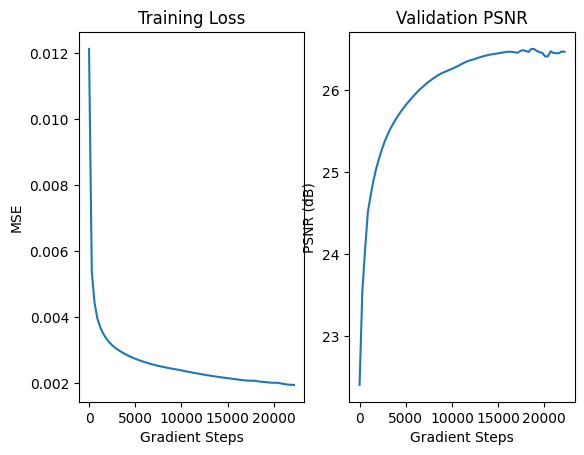

In [32]:
n_train_supervised = 300  # 300 chunks for supervised training
epochs = 75
check_val_every_epochs = 1

lr = 1e-4
batch_size = 32  

supervised_train_subset = Subset(supervised_train_set, range(n_train_supervised))
supervised_train_loader = DataLoader(supervised_train_subset, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)

supervised_model, supervised_train_losses, supervised_val_psnrs = train(
    model=supervised_model, 
    optimizer=torch.optim.Adam(supervised_model.parameters(), lr=lr),
    train_loader=supervised_train_loader,
    epochs=epochs,
    val_loader=val_loader,
    check_val_every_epochs=check_val_every_epochs,
    device=device
)

fig, ax = plt.subplots(1, 2)
ax[0].set_title("Training Loss")
ax[0].plot(supervised_train_losses.keys(), supervised_train_losses.values())
ax[0].set_xlabel("Gradient Steps")
ax[0].set_ylabel("MSE")
ax[1].set_title("Validation PSNR")
ax[1].plot(supervised_val_psnrs.keys(), supervised_val_psnrs.values())
ax[1].set_xlabel("Gradient Steps")
ax[1].set_ylabel("PSNR (dB)")

## Noise2Noise

In [35]:
n_train_val_psnrs = {}
n2n_models = []

for n_train in [300, 600]: 
    n2n_train_subset = Subset(n2n_train_set, range(n_train))
    n2n_train_loader = DataLoader(n2n_train_subset, batch_size=batch_size)
    n2n_model = Unet(
        in_chans=1,  # 1 input channel as we use grayscale images as input
        out_chans=1,  # 1 output channel as the model returns grayscale images
        num_pool_layers=num_pool_layers,
        chans=chans
    ).to(device)
    n2n_model, n2n_train_losses, n2n_val_psnrs = train(
        model=n2n_model, 
        optimizer=torch.optim.Adam(n2n_model.parameters(), lr=lr),
        train_loader=n2n_train_loader,
        epochs=math.ceil((n_train_supervised*epochs)/n_train),  # here, we keep the number of gradient updates conatant as larger datasets require typically fewer epochs
        val_loader=val_loader,
        check_val_every_epochs=check_val_every_epochs,
        device=device
    )
    n2n_models.append(n2n_model)
    n_train_val_psnrs[n_train] = n2n_val_psnrs

Epoch: 100%|██████████| 38/38 [04:03<00:00,  6.40s/it]


## Comparison

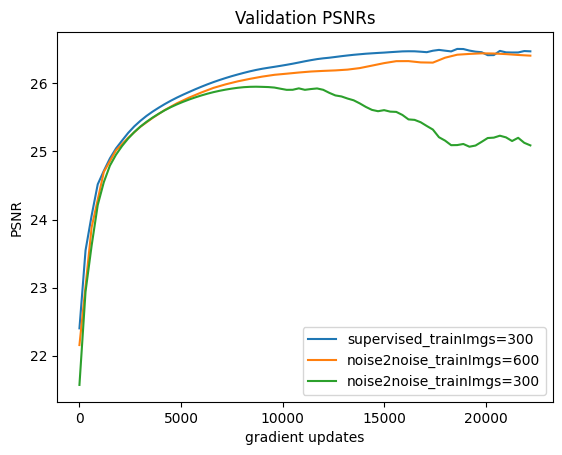

In [39]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Validation PSNRs")
ax.set_xlabel("gradient updates")
ax.set_ylabel("PSNR")
ax.plot(supervised_val_psnrs.keys(), supervised_val_psnrs.values(), label="supervised_trainImgs=300")
for n_train, psnrs in n_train_val_psnrs.items():
    ax.plot(psnrs.keys(), psnrs.values(), label=f"noise2noise_trainImgs={n_train}")
ax.legend(loc="best")

We see that for a dataset of about 600 chunks, Noise2Noise reaches approximately the same performance as the supervised baseline. 300 chunks do not suffice to reach this performance and the model even overfits!